In [44]:
# load variables and configurations

import csv

from utils import convert_symbol_into_usdt
from config import USDT_SYMBOLS, DATA_FOLDER_NAME
abstract_feature_symbols = ["diff_domains"] #, "diff_domains_weighted"]


nb_symbol_limit = 30 # to delerte
nb_symbol_to_currencies_graph_in_bokeh = 3
matplotlib_sequence_length_limit = 6000 # "nolimit"
bokeh_sequence_length_limit = "nolimit" # "nolimit"
bucket_middle = 0.003 # 0.004
estimation_start_date = 1522447200 # 31th of March 2018


selected_symbols = USDT_SYMBOLS[:nb_symbol_limit] # DELETE SELECTED SYNBOLS



In [2]:
# load disk data, SLOW

def get_dict_symbol_rows():
    dict_symbol_rows = {}
    for idx, symbol in enumerate(selected_symbols):
        with open("{}/binance_{}_only_start_price.csv".format(DATA_FOLDER_NAME, symbol), newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            rows = [row for row in spamreader]
                
            dict_symbol_rows[symbol] = rows

        if idx <= 2:
            print("testing if we can read the files correctly")
            print(rows[0])
            print()
    return dict_symbol_rows

dict_symbol_rows = get_dict_symbol_rows()


testing if we can read the files correctly
['1518822000000', '10179.95']

testing if we can read the files correctly
['1518822000000', '942.61247025']

testing if we can read the files correctly
['1518822000000', '1.112668535']



In [45]:
# compute timestamps, prices and diffs

import numpy as np
from collections import defaultdict

mask_length = 60
prices_mask = np.zeros((mask_length,), dtype='float')
prices_mask[mask_length - 1] = -1
prices_mask[0] = 1
timestamps_mask = np.zeros((mask_length,), dtype='float')
timestamps_mask[0] = 1


def get_bucket(value):
    if value <= -bucket_middle:
        return -1
    elif value >= -bucket_middle and value <= bucket_middle:
        return 0
    elif value >= bucket_middle:
        return 1
    

def get_x_y(): 
    d_features_graph_scale = defaultdict(lambda: 1.0) # 1 divided by the first price obtained
    d_symbol_timestamps = {} # timestamps in seconds
    d_symbol_prices = {} # in USDT
    d_symbol_diff = {} # difference of price
    d_symbol_bucket = {} # -1 or 0 or 1
    for idx, symbol in enumerate(selected_symbols):
        timestamps = []
        prices = []
        rows = dict_symbol_rows[symbol]
        for row in rows:
            timestamp = int(row[0]) / 1000
            price = float(row[1])
            timestamps.append(timestamp)
            prices.append(price)

        d_symbol_prices[symbol] = np.array(prices, dtype='float')

        timestamps = np.convolve(timestamps, timestamps_mask, mode = 'valid')
        d_symbol_timestamps[symbol] = timestamps

        diff = np.convolve(prices, prices_mask, mode = 'valid')
        #std = np.std(diff)
        #diff /= std
        d_features_graph_scale[symbol] = 1.0 / prices[0]
        d_symbol_diff[symbol] = diff

        buckets = [get_bucket(value / prices[0]) for value in diff] # ERROR: avaiat oublie de divise par prices[0], dependences ici, car mon code fait 4 trucs en meme temps
        d_symbol_bucket[symbol] = buckets

        if idx == 0:
            print(timestamps.shape)
        assert(timestamps.shape[0] == d_symbol_timestamps["BTCUSDT"].shape[0])
    return d_symbol_timestamps, d_symbol_prices, d_symbol_diff, d_symbol_bucket, d_features_graph_scale


d_symbol_timestamps, d_symbol_prices, d_symbol_diff, d_symbol_bucket, d_features_graph_scale = get_x_y()
    


(74941,)


In [46]:
# compute diff_domain and its weighted version

# ERROR if "diff_domains" in selected_symbols:/ ### UTILISER FONCTION DU MEME NOM POUR PLUSIEURS CONTENT FAIT TACHE ICI !!
#     selected_symbols.remove("diff_domains")
    
    
# diff_domains: sum of buckets divided by number of symbols, value in [-1, 1]
def get_diff_domains_and_weighted_version(s_timestamps):
    diff_domains = np.zeros(s_timestamps.shape)
    #diff_domains_weighted = np.zeros(s_timestamps.shape)
    for symbol in selected_symbols:
        diff_domains += d_symbol_bucket[symbol]
        #weight = d_symbol_weight[symbol]
        #diff_domains_weighted += [x * weight for x in d_symbol_bucket[symbol]]

    diff_domains /= len(selected_symbols)
    d_features_graph_scale["diff_domains"] = 1.0 / 100.0

    #sum_weights = sum([d_symbol_weight[s] for s in d_symbol_weight])
    #diff_domains_weighted /= sum_weights
    #d_features_graph_scale["diff_domains_weighted"] = 1.0 / 100.0
    
    print(diff_domains[0:10])
    #print(diff_domains_weighted[0:10])

    return diff_domains #, diff_domains_weighted


diff_domains = get_diff_domains_and_weighted_version(d_symbol_timestamps["BTCUSDT"])

d_symbol_timestamps["diff_domains"] = d_symbol_timestamps["BTCUSDT"]
d_symbol_diff["diff_domains"] = diff_domains

#d_symbol_timestamps["diff_domains_weighted"] = d_symbol_timestamps["BTCUSDT"] NOT COMPUTED PROPERLY
#d_symbol_diff["diff_domains_weighted"] = diff_domains_weighted



[-0.2        -0.06666667 -0.2        -0.2        -0.5        -0.26666667
 -0.3        -0.4        -0.56666667 -0.56666667]


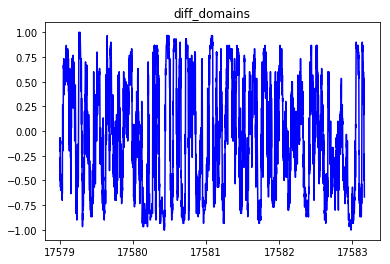

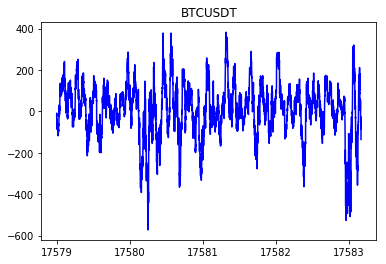

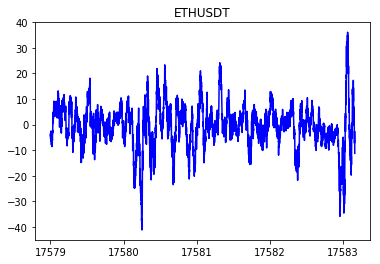

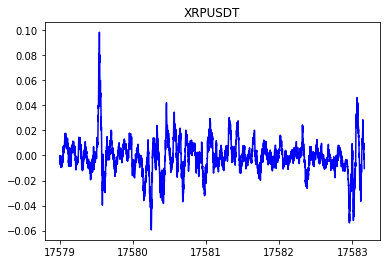

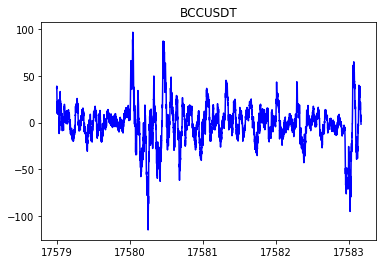

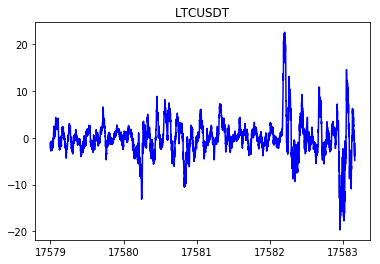

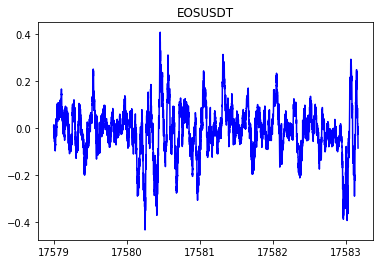

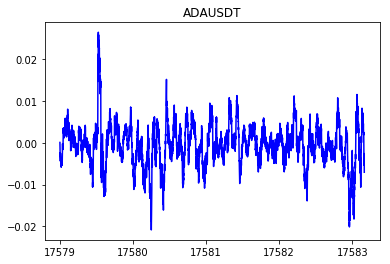

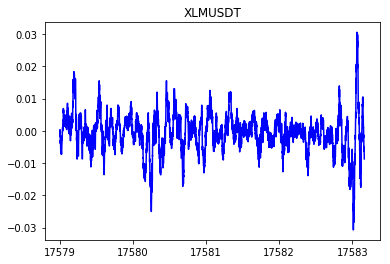

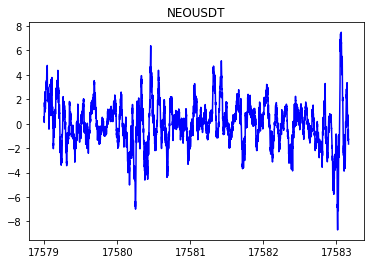

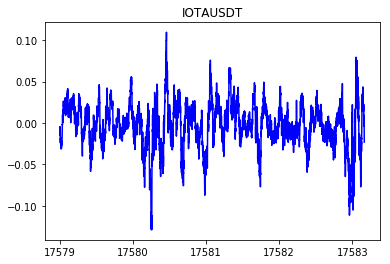

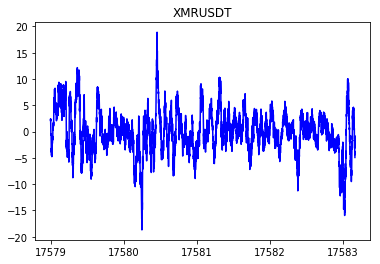

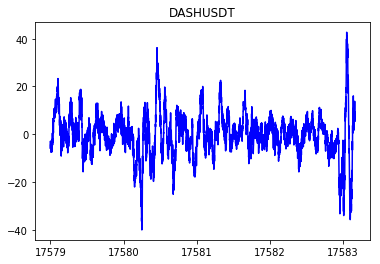

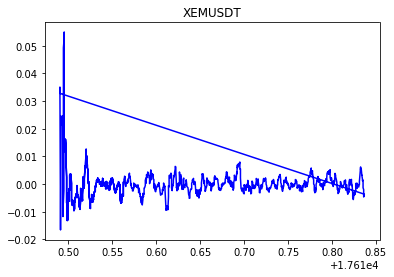

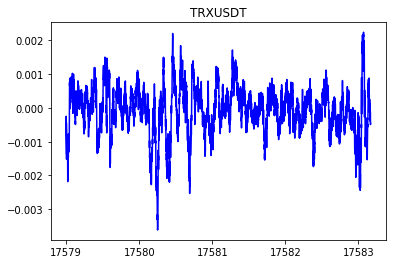

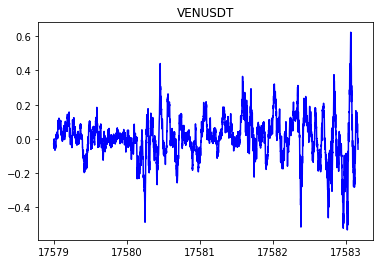

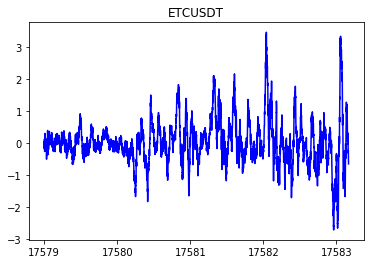

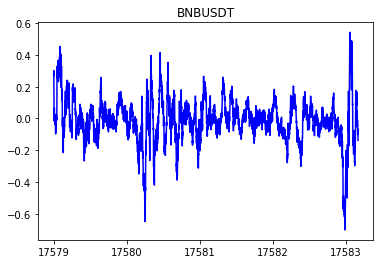

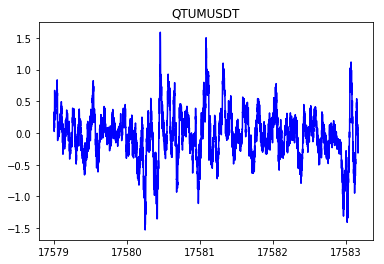

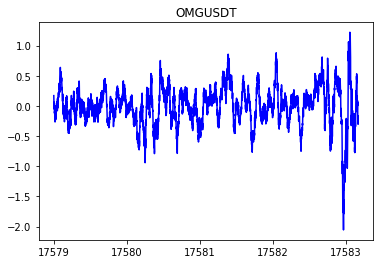

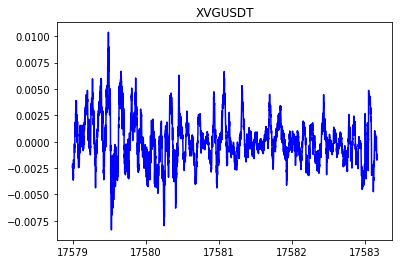

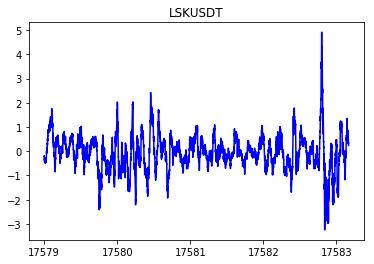

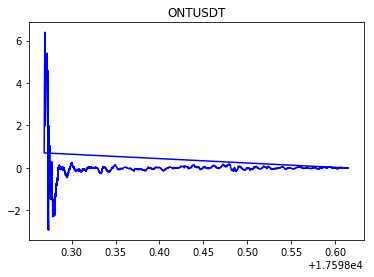

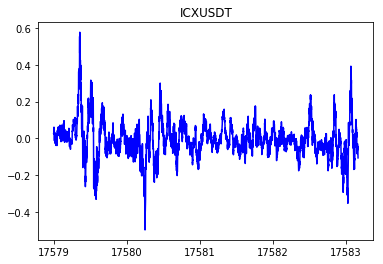

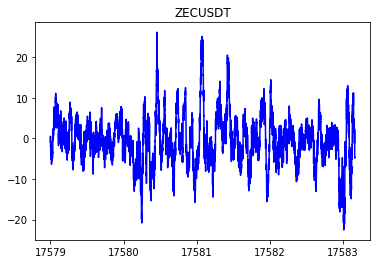

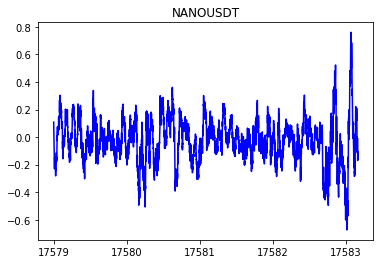

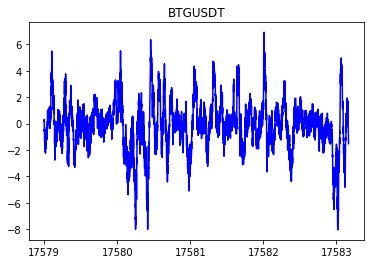

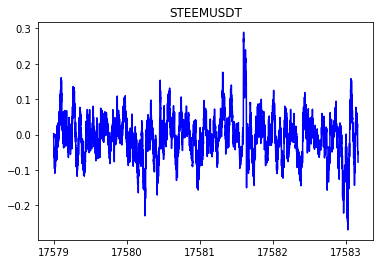

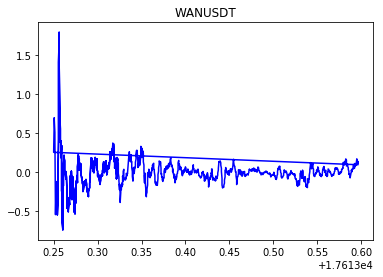

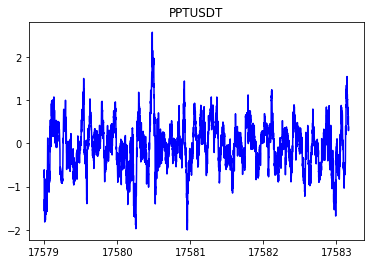

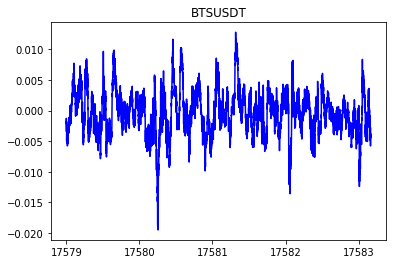

In [47]:
# display matpltolib graphs

%matplotlib inline 
import matplotlib.pyplot as plt


symbols_to_graph_with_patplotlib = abstract_feature_symbols + selected_symbols

# x-axis: number of days
def display_matplotlib_graphs(d_symbol_timestamps, d_symbol_diff, matplotlib_sequence_length_limit):
    for symbol in symbols_to_graph_with_patplotlib:
        x = d_symbol_timestamps[symbol]
        y = d_symbol_diff[symbol]
        
        if matplotlib_sequence_length_limit != "nolimit":
            x = x[:matplotlib_sequence_length_limit]
            y = y[:matplotlib_sequence_length_limit]

        x_per_day = [x_datum / float(24 * 3600) for x_datum in x]
        plt.title(symbol)
        plt.plot(x_per_day, y, c='blue')
        plt.show()
        
display_matplotlib_graphs(d_symbol_timestamps, d_symbol_diff, matplotlib_sequence_length_limit)
    

In [7]:
# add functions display bokeh graphs

from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file

from utils import CATEGORY_20_PALETTE, get_palette_color, CATEGORY_3_DASH_PATTERNS, get_dash_pattern
    
    

symbols_to_graph_in_bokeh = abstract_feature_symbols + selected_symbols[:nb_symbol_to_currencies_graph_in_bokeh]

def display_bokeh_graphs(symbols, d_symbol_timestamps, d_symbol_diff, bokeh_sequence_length_limit):
    fig = figure(title="WARNING: scaled features", x_axis_type="datetime")
    for idx, symbol in enumerate(symbols):
        x = d_symbol_timestamps[symbol]
        y = d_symbol_diff[symbol]

        if bokeh_sequence_length_limit != "nolimit":
            x = x[:bokeh_sequence_length_limit]
            y = y[:bokeh_sequence_length_limit]

        scale_factor = d_features_graph_scale[symbol]
        y = [yi * scale_factor for yi in y]
        fig.line(x, y, line_width=3, legend="{} diff scaled {} times".format(symbol, scale_factor), line_dash=get_dash_pattern(idx), color=get_palette_color(idx))
    show(gridplot([[fig]], plot_width=int(1262 * 0.95), plot_height=int(780 * 0.95)))
    output_file("./graph_features.html", title="")
    


In [ ]:
# display all currencies bokeh graph 

display_bokeh_graphs(symbols_to_graph_in_bokeh, d_symbol_timestamps, d_symbol_diff, bokeh_sequence_length_limit)


In [ ]:
# display "diff_domains" bokeh graph

display_bokeh_graphs(["diff_domains"], d_symbol_timestamps, d_symbol_diff, bokeh_sequence_length_limit)


In [ ]:
# from collections import defaultdict

# def try_winning(symbol):    
#     #d_symbol_minutes_before_retrying = defaultdict(int)
#     minutes_before_retrying = 0.0
#     wins = 0.0 # sum of relative wins
#     keep_for_x_minutes = 15
#     dont_touch_same_currency_for_n_minutes = 60
#     min_diff_domains_weighted_to_buy_or_sell = 0.86 # debug 0.75

#     nb_debug_msgs = 100 # debug

#     nb_bets = 0
#     nb_minutes_since_last_time_action_was_possible = 0
#     for idx, t in enumerate(d_symbol_timestamps[symbol][:-keep_for_x_minutes]): # on joue sur 60 seconds
#         if not t >= estimation_start_date:
#             continue
#         nb_minutes_since_last_time_action_was_possible += 1

#         # first condition to decide to buy
#         diff = d_symbol_diff["diff_domains"][idx]
#         if not (diff >= min_diff_domains_weighted_to_buy_or_sell):
#             continue
            
#         if not minutes_before_retrying == 0:
#             continue
            
#         # second condition to decide to buy
#         bucket = d_symbol_bucket[symbol][idx]
#         condition_to_buy = (bucket == -1) # on fait que achete -1 pour le moment
#         if not condition_to_buy: 
#             continue
            
#         # buying
#         win = d_symbol_prices[symbol][idx + keep_for_x_minutes] - d_symbol_prices[symbol][idx]
#         win /= d_symbol_prices[symbol][idx] #  wins in percentage
#         if nb_debug_msgs > 0:
#             nb_debug_msgs -= 1
#             print(idx, win)
#             #print("{:.4f}".format(float(win)))
#         wins += win 
#         nb_bets +=1
#         minutes_before_retrying = dont_touch_same_currency_for_n_minutes

#         # remove n minutes for everywone
#         minutes_before_retrying = max(0, minutes_before_retrying - nb_minutes_since_last_time_action_was_possible)
#         nb_minutes_since_last_time_action_was_possible = 0

#     price_beginning = d_symbol_prices[symbol][0]
#     price_end = d_symbol_prices[symbol][-1]
#     lazy_wins = (price_end - price_beginning) / price_beginning
        
#     print(symbol)
#     print("lazy_wins = {}".format(lazy_wins))
#     print("wins = {}".format(wins))
#     print("nb_bets = {}".format(nb_bets))
#     print("_____________________________________________________________________ \n")
    

# for symbol in selected_symbols:
#     try_winning(symbol)

    

0.5


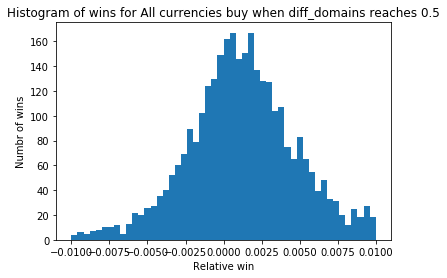

median wins = 0.0012553852334204348
all_won_sums = 4.698044407992493
0.6


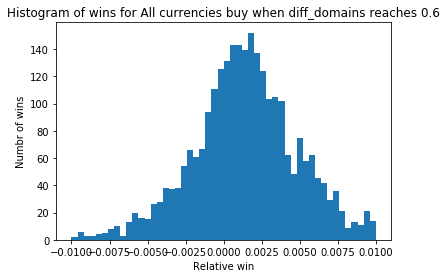

median wins = 0.0015038771659666344
all_won_sums = 4.545786816750131
0.7


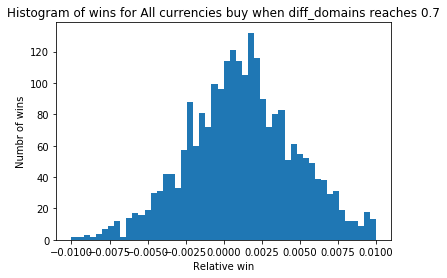

median wins = 0.0012713894592743665
all_won_sums = 3.5666910841772133
0.8


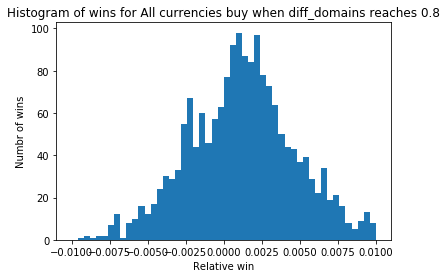

median wins = 0.0013847464595549428
all_won_sums = 2.9400801999643815
0.9


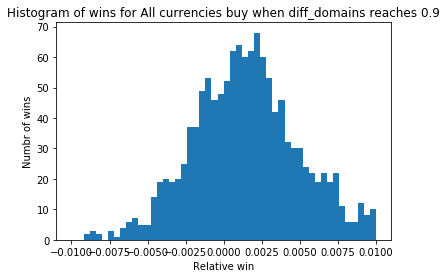

median wins = 0.0015887151095564126
all_won_sums = 2.6514496841109874
0.95


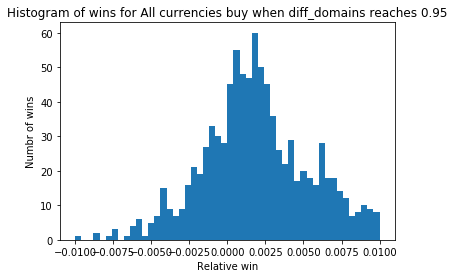

median wins = 0.0018730399298646028
all_won_sums = 2.353481976754303


In [48]:
from collections import defaultdict


# IOTAUSDT
# lazy_wins = -0.5312443952377469
# wins = 0.11148217232292319
# nb_bets = 44


def display_histogram_wins(symbol, win_array):
    if len(win_array) > 0:
        plt.title('Histogram of wins for {}'.format(symbol))
        plt.xlabel('Relative win'.format(np.median(win_array)))
        plt.ylabel('Numbr of wins')
        plt.hist(win_array, bins=50, range=(-0.01, 0.01))
        plt.show()
    
    
def try_winning(min_diff_domains_weighted_to_buy_or_sell, symbol, all_won_bets, all_won_sums, print_log):    
    #d_symbol_minutes_before_retrying = defaultdict(int)
    wins = 0.0 # sum of relative wins
    keep_for_x_minutes = 5
    dont_touch_same_currency_for_n_minutes = 50
    #min_diff_domains_weighted_to_buy_or_sell = 0.86 # debug 0.75

    nb_debug_msgs = 100 # debug
    
    is_first_timestamp_index_set = False
    first_timestamp_index = 0

    nb_bets = 0
    won_bets = 0
    win_array = []
    minutes_before_retrying = 0
    for idx, t in enumerate(d_symbol_timestamps[symbol][:-keep_for_x_minutes]): # on joue sur 60 seconds
        if not t >= estimation_start_date:
            continue
        minutes_before_retrying = max(0, minutes_before_retrying - 1)
        
        # computed first timestamps index where we works according to 'estimation_start_date'
        if not is_first_timestamp_index_set:
            first_timestamp_index = idx
            is_first_timestamp_index_set = True

        # first condition to decide to buy
        diff = d_symbol_diff["diff_domains"][idx]
        if not (diff >= min_diff_domains_weighted_to_buy_or_sell):
            continue
            
        if not minutes_before_retrying == 0:
            continue
            
        # second condition to decide to buy
        bucket = d_symbol_bucket[symbol][idx]
        condition_to_buy = (bucket == 1) # on fait que achete 1 pour le moment
        if not condition_to_buy: 
            continue
            
        # buying
        win = d_symbol_prices[symbol][idx + keep_for_x_minutes] - d_symbol_prices[symbol][idx]
        win /= d_symbol_prices[symbol][idx] #  relative win
        if win > 0: 
            won_bets += 1
        win_array.append(win)
        if nb_debug_msgs > 0:
            nb_debug_msgs -= 1
#             print(idx, win)
            #print("{:.4f}".format(float(win)))
        wins += win 
        nb_bets +=1
        minutes_before_retrying = dont_touch_same_currency_for_n_minutes
        

    price_beginning = d_symbol_prices[symbol][first_timestamp_index]
    price_end = d_symbol_prices[symbol][-1]
    lazy_wins = (price_end - price_beginning) / price_beginning
        
    if print_log:
        print(symbol)
        print("lazy_wins = {}".format(lazy_wins))
        print("wins = {}".format(wins))
        print("nb_bets = {}".format(nb_bets))
        print("won_bets = {}".format(won_bets))
        if nb_bets > 0:
            print("percentage of bets won = {:.2f}".format(won_bets / float(nb_bets)))
        display_histogram_wins(symbol, win_array)
        print("_____________________________________________________________________ \n")
    all_won_bets.extend(win_array)
    
    return all_won_sums + wins
    

for min_diff_domains_weighted_to_buy_or_sell in [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:
    print(min_diff_domains_weighted_to_buy_or_sell)
    all_won_sums = 0
    all_won_bets = []
    
    print_log = False
    for symbol in selected_symbols:
        all_won_sums = try_winning(min_diff_domains_weighted_to_buy_or_sell, symbol, \
                                   all_won_bets, all_won_sums, print_log)
            
    display_histogram_wins("All currencies buy when diff_domains reaches {}" \
                           .format(min_diff_domains_weighted_to_buy_or_sell), all_won_bets)
    print("median wins = {}".format(np.median(all_won_bets)))
    print("all_won_sums = {}".format(all_won_sums))

    

In [ ]:
#%reset_selective d_symbol_minutes_before_retrying

# for symbol in d_symbol_bucket:
#     print(symbol)

In [ ]:
#%reset_selective d_symbol_bucket